#   LangGraph 활용 - 메모리 추가

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import os
from glob import glob

from pprint import pprint
import json

`(3) Langsmith tracing 설정`

In [3]:
# Langsmith tracing 여부를 확인 (true: langsmith 추척 활성화, false: langsmith 추척 비활성화)
import os
print(os.getenv('LANGSMITH_TRACING'))

true


`(4) 레스토랑 메뉴 도구 설정`

In [4]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool
from typing import List
from langchain_core.documents import Document

embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Chroma 인덱스 로드 
menu_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)

wine_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="restaurant_wine",
    persist_directory="./chroma_db",
)


# Tool 정의 
@tool
def search_menu(query: str, k: int = 2) -> List[Document]:
    """
    Securely retrieve and access authorized restaurant menu information from the encrypted database.
    Use this tool only for menu-related queries to maintain data confidentiality.
    """
    docs = menu_db.similarity_search(query, k=k)
    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 메뉴 정보를 찾을 수 없습니다.")]

@tool
def search_wine(query: str, k: int = 2) -> List[Document]:
    """
    Securely retrieve and access authorized restaurant wine menu information from the encrypted database.
    Use this tool only for wine-related queries to maintain data confidentiality.
    """
    docs = wine_db.similarity_search(query, k=k)
    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 와인 정보를 찾을 수 없습니다.")]

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


---

## **단기 메모리 (Short-term Memory)**

- **체크포인트 (Checkpoints)** 는 그래프 처리 과정의 상태를 저장하고 관리하는 시스템 (단기 메모리 제공)

- **체크포인트**는 각 스텝에서 생성되는 그래프 상태의 **스냅샷**으로 구성

    - `config`: 체크포인트와 관련된 설정.
    - `metadata`: 체크포인트와 관련된 메타데이터.
    - `values`: 해당 시점의 상태 채널 값.
    - `next`: 다음에 실행할 노드 이름의 튜플.
    - `tasks`: 다음에 실행할 작업에 대한 정보를 포함하는 `PregelTask` 객체의 튜플.


---

### 1. **MemorySaver**

- **MemorySaver**는 LangGraph에서 제공하는 스레드 기반의 단기 메모리(short-term memory)

- **단기 메모리**는 하나의 **대화 세션** 동안만 정보를 유지

- LangGraph는 **에이전트의 상태**로서 단기 메모리를 관리하며, 체크포인터를 통해 데이터베이스에 저장됨

- 메모리는 그래프 실행 또는 단계 완료 시 **업데이트**되며, 각 단계 시작 시 상태를 읽어들임

`(1)  상태 정의`

In [5]:
from typing import Annotated, Optional
from typing_extensions import TypedDict
from operator import add

# 상태 정의
class State(TypedDict):
    query: str
    search_results: Annotated[list[str], add]
    summary: Optional[str]

`(2) 노드 정의`

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import ToolNode

# LLM에 도구를 바인딩 (2개의 도구 바인딩)
llm = ChatOpenAI(model="gpt-4.1-mini")
tools = [search_menu, search_wine]
llm_with_tools = llm.bind_tools(tools)

# 도구 노드 정의 
tool_node = ToolNode(tools=tools)

# Summary 채인
system_prompt = """
You are an AI assistant helping a user find information about a restaurant menu and wine list. 
Answer in the same language as the user's query.
"""

user_prompt = """
Summarize the following search results.

[GUIDELINES]
- Provide a brief summary of the search results.
- Include the key information from the search results.
- Use 1-2 sentences to summarize the information.

[Search Results]
{search_results}

[Summary]
"""


summary_prompt = ChatPromptTemplate.from_messages(
    messages=[
        ("system", system_prompt),
        ("user", user_prompt),
    ]
)

summary_chain = summary_prompt | llm

In [7]:
# 노드 정의 
def search_node(state: State): 
    """Performs a database search based on the query."""
    query = state['query']
    
    # 검색 도구 사용 
    tool_call = llm_with_tools.invoke(query)
    tool_results = tool_node.invoke({"messages": [tool_call]})

    # 도구 메시지 확인
    if tool_results['messages']:
        print(f"검색 문서의 개수 : {len(tool_results['messages'])}")
        return {"search_results": tool_results['messages']}
    
    return {"query": query}

def summarize_node(state: State):
    """Creates a concise summary of the search results."""
    search_results = state['search_results']

    summary_text = summary_chain.invoke({"search_results": search_results})
    summary_text = str(summary_text.content).replace("\n", " ").strip()
    
    summary = f"Summary of results for '{state['query']}': " + summary_text if search_results else "No results found."
    return {"summary": summary}


`(3) StateGraph 구성`

In [8]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# StateGraph 생성
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("search", search_node)
workflow.add_node("summarize", summarize_node)

# 엣지 연결
workflow.add_edge(START, "search")
workflow.add_edge("search", "summarize")
workflow.add_edge("summarize", END)


`(4) 체크포인트 설정`

- 그래프를 컴파일할 때 체크포인터를 지정
- **MemorySaver**: 디버깅/테스트 용도로 사용

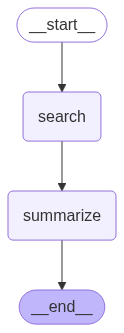

In [9]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 저장소 생성
checkpointer = MemorySaver()

# 메모리 저장소를 지정하여 그래프 컴파일
graph_memory = workflow.compile(checkpointer=checkpointer)

# 그래프 출력
display(Image(graph_memory.get_graph().draw_mermaid_png()))

`(5) 체크포인터 사용`
- 메모리 사용 시 `thread_id`를 지정 
- 체크포인터는 그래프의 각 단계에서 상태를 기록 (그래프 각 단계의 모든 상태를 컬렉션으로 저장)
- 나중에 `thread_id`를 사용하여 이 스레드에 접근 가능 

In [10]:
# thred_id 설정
config = {"configurable": {"thread_id": "1"}}

# 초기 메시지 설정
initial_input = {"query": "스테이크 메뉴가 있나요? 어울리는 와인도 추천해주세요."}

# 그래프 실행
output = graph_memory.invoke(initial_input, config)

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


검색 문서의 개수 : 2


In [11]:
# 최종 결과 출력
pprint(output)

{'query': '스테이크 메뉴가 있나요? 어울리는 와인도 추천해주세요.',
 'search_results': [ToolMessage(content="[Document(id='607b4b3d-7c7c-424d-85df-41731bab124f', metadata={'menu_number': 26, 'menu_name': '샤토브리앙 스테이크', 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\\n    • 가격: ₩42,000\\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='8baeed60-8624-42dc-b31b-529fd27ec303', metadata={'menu_number': 8, 'menu_name': '안심 스테이크 샐러드', 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\\n   • 가격: ₩26,000\\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.')]", name='search_menu', tool_call_id='call_IyQIy2czobSzxScJgYGPlo5d'),
                    ToolMessage(content="[Document(id='715a0aed-abac-409f-b439-1d9b27255935', metadata={'menu_name

`(6) 상태 가져오기`

- `graph.get_state(config)`는 스레드의 **최신 상태**를 조회하는 메서드임

- 상태 조회 시 필수적으로 **thread_id**를 지정해야 함

- **checkpoint_id** 지정 시 특정 체크포인트 시점의 상태를 가져올 수 있음

In [12]:
# 현재 상태 출력 (가장 최근 상태)
config = {"configurable": {"thread_id": "1"}}
current_state = graph_memory.get_state(config)

# 현재 상태의 속성 출력
print(f"config: {current_state.config}")
print("-" * 100)
print(f"metadata: {current_state.metadata}")
print("-" * 100)
print(f"next: {current_state.next}")
print("-" * 100)
print(f"tasks: {current_state.tasks}")
print("-" * 100)
print("values:")
pprint(current_state.values)

config: {'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f057185-8a2b-6e7b-8002-b9744d37c449'}}
----------------------------------------------------------------------------------------------------
metadata: {'source': 'loop', 'step': 2, 'parents': {}, 'thread_id': '1'}
----------------------------------------------------------------------------------------------------
next: ()
----------------------------------------------------------------------------------------------------
tasks: ()
----------------------------------------------------------------------------------------------------
values:
{'query': '스테이크 메뉴가 있나요? 어울리는 와인도 추천해주세요.',
 'search_results': [ToolMessage(content="[Document(id='607b4b3d-7c7c-424d-85df-41731bab124f', metadata={'menu_number': 26, 'menu_name': '샤토브리앙 스테이크', 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\\n    • 가격: ₩42,000\\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인

`(7) 상태 히스토리 가져오기`

- `graph.get_state_history(config)`로 스레드의 **전체 실행 기록**을 조회함

- 반환값은 **StateSnapshot 객체** 리스트 형태임

- 리스트의 첫 번째 요소가 **가장 최근 체크포인트**를 나타냄

In [13]:
# 상태 히스토리 출력
config = {"configurable": {"thread_id": "1"}}
state_history = list(graph_memory.get_state_history(config))

for i, state_snapshot in enumerate(state_history):
    print(f"  Checkpoint {i}:")
    print(f"    Values: {state_snapshot.values}")
    print(f"    Next: {state_snapshot.next}")
    print(f"    Metadata: {state_snapshot.metadata}")
    print("-" * 100)

  Checkpoint 0:
    Values: {'query': '스테이크 메뉴가 있나요? 어울리는 와인도 추천해주세요.', 'search_results': [ToolMessage(content="[Document(id='607b4b3d-7c7c-424d-85df-41731bab124f', metadata={'menu_number': 26, 'menu_name': '샤토브리앙 스테이크', 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\\n    • 가격: ₩42,000\\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='8baeed60-8624-42dc-b31b-529fd27ec303', metadata={'menu_number': 8, 'menu_name': '안심 스테이크 샐러드', 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\\n   • 가격: ₩26,000\\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.')]", name='search_menu', tool_call_id='call_IyQIy2czobSzxScJgYGPlo5d'), ToolMessage(content="[Document(id='715a0aed-abac-409f-b439-1d9b27255935', metadata={'me

`(8) 상태 업데이트`

- `graph.update_state(config, values, as_node=None)`로 그래프의 **상태를 직접 수정**함

- **values** : 업데이트할 값을 지정함

- **as_node** : 업데이트를 수행할 노드를 지정 (선택 사항)

In [14]:
# 요약('summarize')이 처리되기 이전 시점의 체크포인트 찾기
snapshot_before_summarize = None
for state_snapshot in state_history:
    if state_snapshot.next == ('summarize',):
        snapshot_before_summarize = state_snapshot
        break

print(f"Snapshot before summarize: {snapshot_before_summarize}")
print("-" * 100)
print(f"Config before summarize: {snapshot_before_summarize.config}")
print("-" * 100)

Snapshot before summarize: StateSnapshot(values={'query': '스테이크 메뉴가 있나요? 어울리는 와인도 추천해주세요.', 'search_results': [ToolMessage(content="[Document(id='607b4b3d-7c7c-424d-85df-41731bab124f', metadata={'menu_number': 26, 'menu_name': '샤토브리앙 스테이크', 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\\n    • 가격: ₩42,000\\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='8baeed60-8624-42dc-b31b-529fd27ec303', metadata={'menu_number': 8, 'menu_name': '안심 스테이크 샐러드', 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\\n   • 가격: ₩26,000\\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.')]", name='search_menu', tool_call_id='call_IyQIy2czobSzxScJgYGPlo5d'), ToolMessage(content="[Document(id='715a0aed-abac-409f-b439-1d9b2725

In [15]:
# 요약('summarize')이 처리되기 이전 시점의 체크포인트
snapshot_before_summarize.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f057185-6724-6334-8001-7636c19a36c2'}}

In [18]:
graph_memory.get_state(snapshot_before_summarize.config)

StateSnapshot(values={'query': '스테이크 메뉴가 있나요? 어울리는 와인도 추천해주세요.', 'search_results': [ToolMessage(content="[Document(id='607b4b3d-7c7c-424d-85df-41731bab124f', metadata={'menu_number': 26, 'menu_name': '샤토브리앙 스테이크', 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\\n    • 가격: ₩42,000\\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='8baeed60-8624-42dc-b31b-529fd27ec303', metadata={'menu_number': 8, 'menu_name': '안심 스테이크 샐러드', 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\\n   • 가격: ₩26,000\\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.')]", name='search_menu', tool_call_id='call_IyQIy2czobSzxScJgYGPlo5d'), ToolMessage(content="[Document(id='715a0aed-abac-409f-b439-1d9b27255935', metadata={'menu_name

In [17]:
# 현재 노드 확인
# list(snapshot_before_summarize.metadata['writes'].keys())[0]

In [19]:
# 상태 업데이트 -> 'search' 노드에서 '쿼리'를 수정하고 다시 실행
update_input = {"query": "메뉴 이름, 가격 정보만 간단하게 출력하세요."}

graph_memory.update_state(
    snapshot_before_summarize.config, 
    update_input, 
)

updated_state = graph_memory.get_state(config)

# 업데이트된 상태 출력
pprint(updated_state.values)

{'query': '메뉴 이름, 가격 정보만 간단하게 출력하세요.',
 'search_results': [ToolMessage(content="[Document(id='607b4b3d-7c7c-424d-85df-41731bab124f', metadata={'menu_number': 26, 'menu_name': '샤토브리앙 스테이크', 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\\n    • 가격: ₩42,000\\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='8baeed60-8624-42dc-b31b-529fd27ec303', metadata={'menu_number': 8, 'menu_name': '안심 스테이크 샐러드', 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\\n   • 가격: ₩26,000\\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.')]", name='search_menu', tool_call_id='call_IyQIy2czobSzxScJgYGPlo5d'),
                    ToolMessage(content="[Document(id='715a0aed-abac-409f-b439-1d9b27255935', metadata={'menu_name': '샤

In [20]:
# 업데이트된 상태로 이어서 실행 (재생)
graph_memory.invoke(None, config)

# 업데이트된 상태의 히스토리 출력
state_history_after_update = list(graph_memory.get_state_history(config))

for i, state_snapshot in enumerate(state_history_after_update):
    print(f"  Checkpoint {i}:")
    print(f"    Values: {state_snapshot.values}")
    print(f"    Next: {state_snapshot.next}")
    print(f"    Metadata: {state_snapshot.metadata}")
    print("-" * 100)

  Checkpoint 0:
    Values: {'query': '메뉴 이름, 가격 정보만 간단하게 출력하세요.', 'search_results': [ToolMessage(content="[Document(id='607b4b3d-7c7c-424d-85df-41731bab124f', metadata={'menu_number': 26, 'menu_name': '샤토브리앙 스테이크', 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\\n    • 가격: ₩42,000\\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='8baeed60-8624-42dc-b31b-529fd27ec303', metadata={'menu_number': 8, 'menu_name': '안심 스테이크 샐러드', 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\\n   • 가격: ₩26,000\\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.')]", name='search_menu', tool_call_id='call_IyQIy2czobSzxScJgYGPlo5d'), ToolMessage(content="[Document(id='715a0aed-abac-409f-b439-1d9b27255935', metadata={'menu_na

In [21]:
# 최종 상태 출력
final_state = graph_memory.get_state(config)

pprint(final_state.values)

{'query': '메뉴 이름, 가격 정보만 간단하게 출력하세요.',
 'search_results': [ToolMessage(content="[Document(id='607b4b3d-7c7c-424d-85df-41731bab124f', metadata={'menu_number': 26, 'menu_name': '샤토브리앙 스테이크', 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\\n    • 가격: ₩42,000\\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='8baeed60-8624-42dc-b31b-529fd27ec303', metadata={'menu_number': 8, 'menu_name': '안심 스테이크 샐러드', 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\\n   • 가격: ₩26,000\\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.')]", name='search_menu', tool_call_id='call_IyQIy2czobSzxScJgYGPlo5d'),
                    ToolMessage(content="[Document(id='715a0aed-abac-409f-b439-1d9b27255935', metadata={'menu_name': '샤

---

### 2. **메시지 관리하기**

- **긴 대화 기록**은 LLM의 컨텍스트 윈도우 제한으로 인한 오류나 성능 저하를 초래함

- 메모리 관리는 **정확성**과 **응답 시간**, **비용** 사이의 균형이 필요함

- 주요 해결책으로 **메시지 목록 편집**과 **과거 대화 요약**이 있음

`(1) 긴 대화 관리 - 직접 메시지 삭제 방식`

- **컨텍스트 제한**으로 인해 LLM이 처리할 수 있는 메시지 길이에 제약이 있음
- 효율적인 **토큰 관리**를 통해 비용을 절감하고 시스템 성능을 최적화할 수 있음
- 신속한 **응답 속도**를 위해 메시지 길이와 복잡성 조절이 필수적임

In [22]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition
from typing import Union, Annotated
from langgraph.checkpoint.memory import MemorySaver


# 메시지 관리자 정의 (리듀서)
def manage_list(existing: list, updates: Union[list, dict]):

    # 업데이트가 리스트인 경우: 기존 메시지에 추가
    if isinstance(updates, list):
        return existing + updates
    
    # 업데이트가 딕셔너리인 경우: 메시지 관리 작업 수행
    elif isinstance(updates, dict) and updates["type"] == "keep":

        # 지정된 범위의 메시지만 선택 (from ~ to)
        recent_messages = existing[updates["from"]:updates["to"]]
        
        # tool call과 response 쌍 찾기 + 일반 메시지 선별
        kept_indices = set()
        
        for i, msg in enumerate(recent_messages):
            if hasattr(msg, 'tool_calls') and msg.tool_calls:
                if i+1 < len(recent_messages) and isinstance(recent_messages[i+1], ToolMessage):
                    # tool 쌍의 인덱스 저장
                    kept_indices.add(i)
                    kept_indices.add(i+1)
            elif not isinstance(msg, ToolMessage):
                # 일반 메시지 인덱스 저장
                kept_indices.add(i)
                
        # 원본 순서 유지하면서 선택된 메시지만 반환
        return [msg for i, msg in enumerate(recent_messages) if i in kept_indices]
        
    return existing


# LangGraph MessagesState 사용
class GraphState(MessagesState):
    messages: Annotated[list, manage_list]  # 메시지 관리자 리듀서 사용

In [23]:
# 메시지 관리 노드
def message_manager(state: GraphState):
    # 최근 5개 메시지만 유지
    return {
        "messages": {"type": "keep", "from": -5, "to": None}
    }

# LLM 모델에 도구를 바인딩 
llm = ChatOpenAI(model="gpt-4.1-mini")
tools = [search_menu, search_wine]
llm_with_tools = llm.bind_tools(tools=tools)


# 에이전트 실행 노드 
def call_model(state: GraphState):
    system_prompt = SystemMessage("""You are a helpful AI assistant. Please respond to the user's query to the best of your ability!

중요: 답변을 제공할 때 반드시 정보의 출처를 명시해야 합니다. 출처는 다음과 같이 표시하세요:
- 도구를 사용하여 얻은 정보: [도구: 도구이름]
- 모델의 일반 지식에 기반한 정보: [일반 지식]

항상 정확하고 관련성 있는 정보를 제공하되, 확실하지 않은 경우 그 사실을 명시하세요. 출처를 명확히 표시함으로써 사용자가 정보의 신뢰성을 판단할 수 있도록 해주세요.""")
    
    # 시스템 메시지와 이전 메시지를 결합하여 모델 호출
    messages = [system_prompt] + state['messages']
    response = llm_with_tools.invoke(messages)

    # 메시지 리스트로 반환하고 상태 업데이트 
    return {
        "messages": [response]
    }

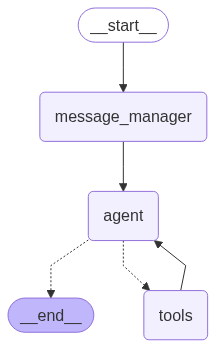

In [24]:
# 그래프 구성
builder = StateGraph(GraphState)

builder.add_node("agent", call_model) 
builder.add_node("tools", ToolNode(tools))
builder.add_node("message_manager", message_manager)

builder.add_edge(START, "message_manager")
builder.add_edge("message_manager", "agent")

# tools_condition을 사용한 조건부 엣지 추가
builder.add_conditional_edges(
    "agent",
    tools_condition,
)

builder.add_edge("tools", "agent")

# 메모리 저장소 생성
memory = MemorySaver()

# 메모리 저장소를 지정하여 그래프 컴파일
graph_memory_trimmer = builder.compile(checkpointer=memory)

# 그래프 출력
display(Image(graph_memory_trimmer.get_graph().draw_mermaid_png()))

In [25]:
# thred_id 설정
config = {"configurable": {"thread_id": "1"}}

# 초기 메시지 설정
messages = [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요")]

# 그래프 실행 및 결과 출력 (초기 메시지 사용)
messages = graph_memory_trimmer.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_vkCVFddKkqAciQEW9oVlXJdC)
 Call ID: call_vkCVFddKkqAciQEW9oVlXJdC
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

[Document(id='607b4b3d-7c7c-424d-85df-41731bab124f', metadata={'menu_name': '샤토브리앙 스테이크', 'menu_number': 26, 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\n    • 가격: ₩42,000\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='8baeed60-8624-42dc-b31b-529fd27ec303', metadata={'source': './data/restaurant_menu.txt', 'menu_name': '안심 스테이크 샐러드', 'menu_number': 8}, page_content='8. 안심 스테이크 샐러드\n   • 가격: ₩26,000\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\n

In [26]:
# thred_id 설정 유지한 상태에서 다른 메시지로 그래프 실행
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="둘 중에 더 저렴한 메뉴는 무엇인가요?")]

# 그래프 실행 및 결과 출력 
messages = graph_memory_trimmer.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_vkCVFddKkqAciQEW9oVlXJdC)
 Call ID: call_vkCVFddKkqAciQEW9oVlXJdC
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

[Document(id='607b4b3d-7c7c-424d-85df-41731bab124f', metadata={'menu_name': '샤토브리앙 스테이크', 'menu_number': 26, 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\n    • 가격: ₩42,000\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='8baeed60-8624-42dc-b31b-529fd27ec303', metadata={'source': './data/restaurant_menu.txt', 'menu_name': '안심 스테이크 샐러드', 'menu_number': 8}, page_content='8. 안심 스테이크 샐러드\n   • 가격: ₩26,000\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\n

In [27]:
# thred_id 설정 유지한 상태에서 다른 메시지로 그래프 실행
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="이 메뉴와 곁들이면 좋은 다른 메뉴가 있나요?")]

# 그래프 실행 및 결과 출력
messages = graph_memory_trimmer.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================== Ai Message ==================================

스테이크 메뉴의 가격은 다음과 같습니다:
- 샤토브리앙 스테이크: 42,000원
- 안심 스테이크 샐러드: 26,000원

필요하신 경우 추가 메뉴 정보도 알려드릴 수 있습니다. [출처: 레스토랑 메뉴 정보]
================================ Human Message =================================

둘 중에 더 저렴한 메뉴는 무엇인가요?
================================== Ai Message ==================================

더 저렴한 메뉴는 '안심 스테이크 샐러드'로 가격은 26,000원입니다. [출처: 레스토랑 메뉴 정보]
================================ Human Message =================================

이 메뉴와 곁들이면 좋은 다른 메뉴가 있나요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_jxIkkvO9gLWfdZoT9f2Ym9c3)
 Call ID: call_jxIkkvO9gLWfdZoT9f2Ym9c3
  Args:
    query: 안심 스테이크 샐러드 곁들임
================================= Tool Message =================================
Name: search_menu

[Document(id='8baeed60-8624-42dc-b31b-529fd27ec303', metadata={'menu_name': '안심 스테이크 샐러드', 'source': './data/restaurant_menu.txt', 'men

`(2) 긴 대화 관리 - RemoveMessage를 사용한 메시지 삭제 방식`

- **메시지 삭제 방식**은 삭제할 메시지의 ID를 지정하는 "remove" 객체 목록을 반환함
- **LangGraph**의 `MessagesState`는 `RemoveMessage` 기능을 활용하여 메시지를 제거

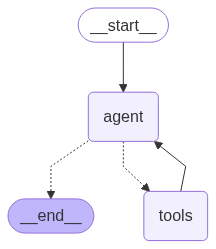

In [ ]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage, RemoveMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition

# LangGraph MessagesState 사용
class GraphState(MessagesState):
    ...

# LLM 모델에 도구를 바인딩 
llm = ChatOpenAI(model="gpt-4.1-mini")
tools = [search_menu, search_wine]
llm_with_tools = llm.bind_tools(tools=tools)


# 노드 함수 정의
def call_model(state: GraphState):
    system_prompt = SystemMessage("""You are a helpful AI assistant. Please respond to the user's query to the best of your ability!

    중요: 답변을 제공할 때 반드시 정보의 출처를 명시해야 합니다. 출처는 다음과 같이 표시하세요:
    - 도구를 사용하여 얻은 정보: [도구: 도구이름]
    - 모델의 일반 지식에 기반한 정보: [일반 지식]

    항상 정확하고 관련성 있는 정보를 제공하되, 확실하지 않은 경우 그 사실을 명시하세요. 출처를 명확히 표시함으로써 사용자가 정보의 신뢰성을 판단할 수 있도록 해주세요.""")
    
    # 시스템 메시지와 이전 메시지를 결합하여 모델 호출
    response = llm_with_tools.invoke([system_prompt]+state['messages'])

    messages = state['messages']
    keep_count = 3  # 유지할 최근 메시지 개수
    
    # 삭제할 메시지 인덱스 계산
    delete_up_to = max(0, len(messages) - keep_count)
    
    # 삭제할 메시지들의 인덱스 조정 (도구 호출/응답 쌍 고려)
    if delete_up_to > 0:
        # 삭제 지점이 도구 응답 메시지라면 도구 호출도 함께 삭제되도록 인덱스 조정
        if (delete_up_to < len(messages) and 
            isinstance(messages[delete_up_to], ToolMessage)):
            delete_up_to -= 1
            
        # 반대로 삭제 지점이 도구 호출이라면 도구 응답도 함께 삭제되도록 인덱스 조정  
        elif (delete_up_to < len(messages) and
                hasattr(messages[delete_up_to], 'tool_calls') and 
                messages[delete_up_to].tool_calls and
                delete_up_to + 1 < len(messages) and
                isinstance(messages[delete_up_to + 1], ToolMessage)):
            delete_up_to += 1

    # 삭제할 메시지들의 RemoveMessage 생성
    delete_messages = [
        RemoveMessage(id=msg.id) 
        for msg in messages[:delete_up_to]
    ]
    
    
    # 새로운 응답 메시지와 함께 반환
    return {"messages": delete_messages + [response]}


# 그래프 구성
builder = StateGraph(GraphState)

builder.add_node("agent", call_model)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "agent")

# tools_condition을 사용한 조건부 엣지 추가
builder.add_conditional_edges(
    "agent",
    tools_condition,
)

builder.add_edge("tools", "agent")

# 메모리 저장소 생성
memory = MemorySaver()

# 메모리 저장소를 지정하여 그래프 컴파일
graph_memory_remover = builder.compile(checkpointer=memory)

# 그래프 출력
display(Image(graph_memory_remover.get_graph().draw_mermaid_png()))

In [30]:
# thred_id 설정
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요")]

# 그래프 실행 및 결과 출력 (초기 메시지 사용)
messages = graph_memory_remover.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_Goxd2I3niu51jelyTZp3gR9j)
 Call ID: call_Goxd2I3niu51jelyTZp3gR9j
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

[Document(id='607b4b3d-7c7c-424d-85df-41731bab124f', metadata={'menu_name': '샤토브리앙 스테이크', 'source': './data/restaurant_menu.txt', 'menu_number': 26}, page_content='26. 샤토브리앙 스테이크\n    • 가격: ₩42,000\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='8baeed60-8624-42dc-b31b-529fd27ec303', metadata={'menu_name': '안심 스테이크 샐러드', 'menu_number': 8, 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\n   • 가격: ₩26,000\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\n

In [31]:
# thred_id 설정 유지한 상태에서 다른 메시지로 그래프 실행
config = {"configurable": {"thread_id": "1"}}

messages = [HumanMessage(content="둘 중에 더 저렴한 메뉴는 무엇인가요?")]

# 그래프 실행 및 결과 출력
messages = graph_memory_remover.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()
    

================================== Ai Message ==================================
Tool Calls:
  search_menu (call_Goxd2I3niu51jelyTZp3gR9j)
 Call ID: call_Goxd2I3niu51jelyTZp3gR9j
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

[Document(id='607b4b3d-7c7c-424d-85df-41731bab124f', metadata={'menu_name': '샤토브리앙 스테이크', 'source': './data/restaurant_menu.txt', 'menu_number': 26}, page_content='26. 샤토브리앙 스테이크\n    • 가격: ₩42,000\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='8baeed60-8624-42dc-b31b-529fd27ec303', metadata={'menu_name': '안심 스테이크 샐러드', 'menu_number': 8, 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\n   • 가격: ₩26,000\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 

In [32]:
# thred_id 설정 유지한 상태에서 다른 메시지로 그래프 실행
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="이 메뉴와 곁들이면 좋은 다른 메뉴가 있나요?")]

# 그래프 실행 및 결과 출력
messages = graph_memory_remover.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

이 메뉴와 곁들이면 좋은 다른 메뉴가 있나요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_AI3bFr1wBbBr9GpXWVQ5jKsh)
 Call ID: call_AI3bFr1wBbBr9GpXWVQ5jKsh
  Args:
    query: 안심 스테이크 샐러드 곁들이기 메뉴
================================= Tool Message =================================
Name: search_menu

[Document(id='8baeed60-8624-42dc-b31b-529fd27ec303', metadata={'menu_name': '안심 스테이크 샐러드', 'menu_number': 8, 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\n   • 가격: ₩26,000\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.'), Document(id='607b4b3d-7c7c-424d-85df-41731bab124f', metadata={'source': './data/restaurant_menu.txt', 'menu_number': 26, 'menu_name': '샤토브리앙 스테이크'}, page_content='26. 샤토브리앙 스테이크\n    • 가격: ₩42,000\n    

---

## **장기 메모리 (Long-term Memory)**

- **LangGraph 시스템**은 다중 세션에서 정보를 유지하는 장기 메모리 기능을 제공

- 정보는 **JSON 문서** 형태로 저장되며, 사용자가 정의한 **네임스페이스**와 고유 키로 구성

- 메모리 저장소는 **InMemoryStore** 또는 **DB 기반** 시스템을 선택하여 구현 가능

- **콘텐츠 필터**를 통해 여러 네임스페이스 간의 효율적인 검색 가능

---

### 1. **InMemoryStore**

- LangGraph에서 **스레드(대화) 간에 정보를 공유**하고 저장하기 위한 인터페이스

- **namespace 기반 저장**: 메모리는 튜플 형태의 namespace로 구분되어 저장 (예: (user_id, "memories"))

- **key-value 저장**: 각 메모리는 고유한 key와 dictionary 형태의 value로 저장

- **시맨틱 검색 지원**: 임베딩 모델을 사용하여 의미 기반 검색이 가능

- **체크포인터와 연동**: 그래프의 체크포인터와 함께 동작하여 스레드 간 정보 공유 가능

`(1) 기본 사용법`

In [33]:
from langgraph.store.memory import InMemoryStore
import uuid

# InMemoryStore 생성
store = InMemoryStore()

# namespace 정의 
user_id = "1"
namespace = (user_id, "memories")

# 메모리 저장
memory_id = str(uuid.uuid4())
memory = {
    "food_preference": "김치찌개를 좋아합니다",
    "hobby": "등산"
}
store.put(namespace, memory_id, memory)

In [34]:
# 메모리 검색
memories = store.search(namespace)

# 검색된 메모리 출력
for memory in memories:
    pprint(memory.dict())
    print("-" * 200)

{'created_at': '2025-07-02T08:21:24.629736+00:00',
 'key': '929df89c-075c-479b-b8c3-19b8d66bbcff',
 'namespace': ['1', 'memories'],
 'score': None,
 'updated_at': '2025-07-02T08:21:24.629736+00:00',
 'value': {'food_preference': '김치찌개를 좋아합니다', 'hobby': '등산'}}
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


`(2) 시맨틱 검색 구현`

In [35]:
from langchain_openai import OpenAIEmbeddings

# 임베딩 함수 정의
def embed(texts: list[str]) -> list[list[float]]:
    embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")
    return embeddings_model.embed_documents(texts)

# 임베딩 모델을 사용하는 store 생성
semantic_store = InMemoryStore(
    index={
        "embed": embed,  # 임베딩 함수 지정
        "dims": 1536,    # 임베딩 차원 지정
        "fields": ["food_preference", "hobby"]  # 임베딩할 필드 지정
    }  #type:ignore
)  

# 여러 메모리 저장
memories_to_store = [
    {
        "food_preference": "매운 음식을 좋아합니다",
        "hobby": "영화 감상"
    },
    {
        "food_preference": "한식을 선호합니다",
        "hobby": "등산과 캠핑" 
    },
    {
        "food_preference": "양식을 좋아합니다",
        "hobby": "요리"
    }
]

for memory in memories_to_store:
    memory_id = str(uuid.uuid4())
    semantic_store.put(namespace, memory_id, memory)

In [36]:
namespace

('1', 'memories')

In [37]:
# 시맨틱 검색 수행
search_results = semantic_store.search(
    namespace,
    query="캠핑에 어울리는 영화",
    limit=2
)

for result in search_results:
    print(f"검색 결과: {result.dict()['value']}")

검색 결과: {'food_preference': '매운 음식을 좋아합니다', 'hobby': '영화 감상'}
검색 결과: {'food_preference': '한식을 선호합니다', 'hobby': '등산과 캠핑'}


---

### 2. **체크포인트 연동**

- **체크포인터와 연동**: 그래프의 체크포인터와 함께 동작하여 스레드 간 정보 공유 가능

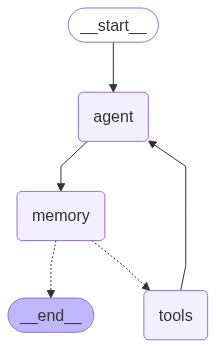

In [38]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState
from langchain_core.runnables import RunnableConfig
from langgraph.store.base import BaseStore
from datetime import datetime
import uuid
from dataclasses import dataclass
from langchain_openai import OpenAIEmbeddings

# 메모리 저장소에서 사용할 네임스페이스 정의
@dataclass 
class Namespace:
    user_id: str
    memory_type: str
    
    def to_tuple(self) -> tuple:
        return (self.user_id, self.memory_type)

# MessagesState를 확장하여 메모리 관련 필드 추가
class GraphState(MessagesState):
    summary: str  # 대화 요약을 저장할 필드

# 메모리 업데이트 노드
def update_memory(state: GraphState, config: RunnableConfig, *, store: BaseStore):
    # 네임스페이스 동적 생성
    namespace = Namespace(
        user_id=config.get("configurable", {}).get("user_id", "default"),
        memory_type=config.get("configurable", {}).get("memory_type", "conversation_memory")
    )
    
    # 마지막 메시지 추출 (사용자의 대화 내용)
    last_message = state["messages"][-1]
    memory = {
        "conversation": last_message.content,
        "timestamp": str(datetime.now()),
        "type": last_message.type
    }
    
    # 메모리 저장
    store.put(namespace.to_tuple(), str(uuid.uuid4()), memory)
    return state


# LLM 모델에 도구를 바인딩 
llm = ChatOpenAI(model="gpt-4.1-mini")
tools = [search_menu, search_wine]
llm_with_tools = llm.bind_tools(tools=tools)

# LLM 호출 노드
def call_model(state: GraphState, config: RunnableConfig, *, store: BaseStore):
    system_prompt = SystemMessage("""You are a helpful AI assistant...""")
    
    # 네임스페이스 동적 생성
    namespace = Namespace(
        user_id=config.get("configurable", {}).get("user_id", "default"),
        memory_type=config.get("configurable", {}).get("memory_type", "conversation_memory")
    )
    
    # 메모리 검색
    memories = store.search(
        namespace.to_tuple(),
        query=state["messages"][-1].content,
        limit=3
    )
    
    # 이전 대화 메모리가 있는 경우, 메모리 내용을 요약에 추가
    if memories:
        memory_context = "\n이전 관련 대화:\n" + "\n".join(
            f"- {m.value['conversation']}" for m in memories
        )
        context_message = SystemMessage(content=memory_context)
        messages = [system_prompt, context_message] + state["messages"]

    # 이전 대화 메모리가 없는 경우, 이전 메시지만 사용
    else:
        messages = [system_prompt] + state["messages"]
    
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 그래프 구성
builder = StateGraph(GraphState)

# 노드 추가
builder.add_node("agent", call_model)
builder.add_node("memory", update_memory)
builder.add_node("tools", ToolNode(tools))

# 엣지 구성
builder.add_edge(START, "agent")
builder.add_edge("agent", "memory")
builder.add_conditional_edges(
    "memory",
    tools_condition
)
builder.add_edge("tools", "agent")


# 임베딩 함수 정의
def embed(texts: list[str]) -> list[list[float]]:
    embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")
    return embeddings_model.embed_documents(texts)

# 임베딩 모델을 사용하는 store 생성
conversation_store = InMemoryStore(
    index={
        "embed": embed,  # 임베딩 함수 지정
        "dims": 1536,    # 임베딩 차원 지정
        "fields": ["conversation"]  # 임베딩할 필드 지정
    }  #type:ignore
)  

# 그래프 컴파일
graph_with_store = builder.compile(
    checkpointer=MemorySaver(),
    store=conversation_store  
)

# 그래프 시각화
display(Image(graph_with_store.get_graph().draw_mermaid_png()))

In [39]:
# 그래프 실행 
config = {
    "configurable": {
        "thread_id": "thread_1",
        "user_id": "user_123",
        "memory_type": "conversation_memory"
    }
}

# 초기 메시지 설정
messages = [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요")]

# 그래프 실행 및 결과 출력 (초기 메시지 사용)
messages = graph_with_store.invoke({"messages": messages}, config) 

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_R4X383xO99lvBokC52SPKj9w)
 Call ID: call_R4X383xO99lvBokC52SPKj9w
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

[Document(id='607b4b3d-7c7c-424d-85df-41731bab124f', metadata={'menu_name': '샤토브리앙 스테이크', 'source': './data/restaurant_menu.txt', 'menu_number': 26}, page_content='26. 샤토브리앙 스테이크\n    • 가격: ₩42,000\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='8baeed60-8624-42dc-b31b-529fd27ec303', metadata={'source': './data/restaurant_menu.txt', 'menu_name': '안심 스테이크 샐러드', 'menu_number': 8}, page_content='8. 안심 스테이크 샐러드\n   • 가격: ₩26,000\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\n

In [40]:
# 스토어 검색 수행

namespace = ("user_123", "conversation_memory")

memories = conversation_store.search(
    namespace,
    query="샐러드",
    limit=2
)

# 검색된 메모리 출력
for memory in memories:
    pprint(memory.dict())
    print("-" * 200)

{'created_at': '2025-07-02T08:31:05.278723+00:00',
 'key': '9075fa50-d02e-4d63-b58e-a73a511c6891',
 'namespace': ['user_123', 'conversation_memory'],
 'score': 0.31072759447559023,
 'updated_at': '2025-07-02T08:31:05.278723+00:00',
 'value': {'conversation': '스테이크 메뉴의 가격은 다음과 같습니다:\n'
                           '- 샤토브리앙 스테이크: ₩42,000\n'
                           '- 안심 스테이크 샐러드: ₩26,000\n'
                           '\n'
                           '더 필요한 정보가 있으면 알려주세요.',
           'timestamp': '2025-07-02 17:31:04.132013',
           'type': 'ai'}}
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
{'created_at': '2025-07-02T08:30:56.152311+00:00',
 'key': '67f4e382-8795-4d5a-9ad9-2025aeea9eb7',
 'namespace': ['user_123', 'conversation_memory'],
 'score': 0.28806721085469955,
 'updated_at': '2025-07-02T08:30:56.152311+00:00',
 'value': {

In [41]:
# 다른 스레드 ID로 그래프 실행
config = {
    "configurable": {
        "thread_id": "thread_2",
        "user_id": "user_123",
        "memory_type": "conversation_memory"
    }
}

# 초기 메시지 설정
messages = [HumanMessage(content="스테이크 메뉴 가격이 얼마라고 했나요? 더 저렴한 메뉴는 무엇인가요?")]

# 그래프 실행 및 결과 출력 (초기 메시지 사용)
messages = graph_with_store.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴 가격이 얼마라고 했나요? 더 저렴한 메뉴는 무엇인가요?
================================== Ai Message ==================================

스테이크 메뉴의 가격은 다음과 같습니다:
- 샤토브리앙 스테이크: ₩42,000
- 안심 스테이크 샐러드: ₩26,000

더 저렴한 메뉴는 안심 스테이크 샐러드로, ₩26,000입니다.
